In [1]:
import pandas as pd
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
Le = LabelEncoder()
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler

In [2]:
fraud = pd.read_csv('fraud_credit_card.csv', index_col=None)
fraud = fraud.loc[:, ~fraud.columns.str.contains('^Unnamed')]

In [3]:
fraud.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [4]:
len(fraud)

555719

In [5]:
fraud.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [6]:
fraud.dtypes

trans_date_trans_time     object
cc_num                   float64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [7]:
fraud = fraud.drop(['trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'lat', 'long', 
                   'dob', 'trans_num', 'unix_time'], axis=1)
#dropping columns that wouldn't help determine whether fraud happened or not 
#ex. the transaction number is unique and wouldn't have an affect on the possibility of fraud 

In [8]:
fraud.head()

,merchant,category,amt,gender,zip,city_pop,job,merch_lat,merch_long,is_fraud
0,fraud_Kirlin and Sons,personal_care,2.86,M,29209,333497,Mechanical engineer,33.986391,-81.200714,0
1,fraud_Sporer-Keebler,personal_care,29.84,F,84002,302,"Sales professional, IT",39.450498,-109.960431,0
2,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,F,11710,34496,"Librarian, public",40.495810,-74.196111,0
3,fraud_Haley Group,misc_pos,60.05,M,32780,54767,Set designer,28.812398,-80.883061,0
4,fraud_Johnston-Casper,travel,3.19,M,49632,1126,Furniture designer,44.959148,-85.884734,0


In [9]:
fraud.dtypes

merchant       object
category       object
amt           float64
gender         object
zip             int64
city_pop        int64
job            object
merch_lat     float64
merch_long    float64
is_fraud        int64
dtype: object

In [10]:
is_fraud = len(fraud[fraud['is_fraud'] == 1])
fraud_prop = is_fraud / len(fraud)
fraud_perc = fraud_prop * 100
print('The number of times fraud occurs in the data set is: ', is_fraud)
print('The percentage where there is fraud in the dataset is:', fraud_perc)

#i want to know how many times fraud occurs so I can compare it to the false negatives in my confusion matrix 

The number of times fraud occurs in the data set is:  2145
The percentage where there is fraud in the dataset is: 0.3859864427885316


In [11]:
#need to do target encoding on the object attributes 
#replace each job category with the average fraud rate for that job across the dataset
#finds association between certain jobs and the likelihood of fradulent activity 
#I'm using target encoding because the job attribute has almost 500 unique values, so one-hot encoding would 
#overload the decision tree 
#can lead to over fitting - I'm hoping that using a max deth will counteract this 
#could use frequecy-encoding - but it seems like there would be more of a relationship between the job and 
#likelihood of fraud 

job_target_mean = fraud.groupby('job')['is_fraud'].mean()
fraud['job_target'] = fraud['job'].map(job_target_mean)

#gender I can one-hot-encode because the results is either 'M' or 'F'

fraud['gender'] = Le.fit_transform(fraud['gender'])

#the category attribute has 14 unique entries so I'll use frequency encoding here 
#I'm using frequency encoding because I don't want to assume that there is a relationship between fraud and what 
#the customer is buying 

category_target_mean = fraud.groupby('category')['is_fraud'].mean()
fraud['category_frequency_encoded'] = fraud['category'].map(category_target_mean)

#the merchant attribute has almost 700 unique entries, so I'll use target encoding here too
#using target over frequency encoding because I could see a more clear relationship between the merchanct and 
#the risk of fraud - like if they don't have good security or encryption 

merchant_target_mean = fraud.groupby('merchant')['is_fraud'].mean()
fraud['merchant_target'] = fraud['merchant'].map(merchant_target_mean)

In [12]:
X = fraud.drop(['job', 'category', 'merchant', 'is_fraud'], axis = 1)
y = fraud['is_fraud']

X.dtypes
#making sure that all of my attributes are either float or intergers, object attributes will not work in ML models 

amt                           float64
gender                          int64
zip                             int64
city_pop                        int64
merch_lat                     float64
merch_long                    float64
job_target                    float64
category_frequency_encoded    float64
merchant_target               float64
dtype: object

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#training my data on 80% of the dataset and testing the rest on the remaining 20%

smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)
#SMOTE oversamples the minority class by creating more of the minority class
#downfall is that it could create data that doesn't make sense in the scope of the problem 

scaler = StandardScaler()

#randomly sampling rows for the SVM
X_train_sample = X_train.sample(frac=0.20, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index] #extracts y values from the corresponding selected X values 
#getting my sample data from 20% of the rows in the dataframe
#especially useful for the SVM where the time complexity depends on the number of rows 

X_train_oversampled_smote, y_train_oversampled_smote = smote.fit_resample(X_train_sample, y_train_sample)
#uses SMOTE to oversample minority class from 20% of the rows 
X_train_over_smote, y_train_over_smote = smote.fit_resample(X_train, y_train)
#uses SMOTE to oversample minority class from all the rows in the training data 
X_train_oversampled_smote_scaled = scaler.fit_transform(X_train_oversampled_smote)
#scaling the oversampled SMOTE data 
X_test_scaled = scaler.transform(X_test)
#scaling all of the X_test values 

rus = RandomUnderSampler(random_state=42)
#under sampling reduces the majority class to be the same size as minority class 
#didn't end up using because there are so few instances of fraud that the models didn't have enough to train on
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_sample, y_train_sample)
#uses undersampling from the majority class on 20% of the rows 
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
#uses undersampling from the majority class on all the training rows
X_train_undersampled_scaled = scaler.fit_transform(X_train_undersampled)
#scaling the undersampled data for training on the 20% of rows 


X_train_sample_scaled = scaler.fit_transform(X_train_sample)
#scaling the X_train on the 20% of rows 

#ensemble methods
rf_model = RandomForestClassifier(max_depth=3, random_state=42)
#using random forest as my ensemble method
meta_model = LogisticRegression()
#requires a meta model, I'm using logistic regression as it is the most recommended meta model 

#try random oversampling 
ros = RandomOverSampler(random_state=42)
#another over sampling tactic but this time it duplicates the fradulent data and reduces the majority class, 
#rather than creating data 
#could overfit if there's not enough fradulent data

X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train_sample, y_train_sample)
X_train_oversampled_scaled = scaler.fit_transform(X_train_oversampled)

In [14]:
print(y_train_oversampled[y_train_oversampled == 1].sum())
len(y_train_oversampled[y_train_oversampled == 0])
#testing the length of the data I plan on using for training 

88556


88556

The area under the ROC curve is:  0.9813079873776519
The area under the precision-recall curve is: 0.4175399284469256


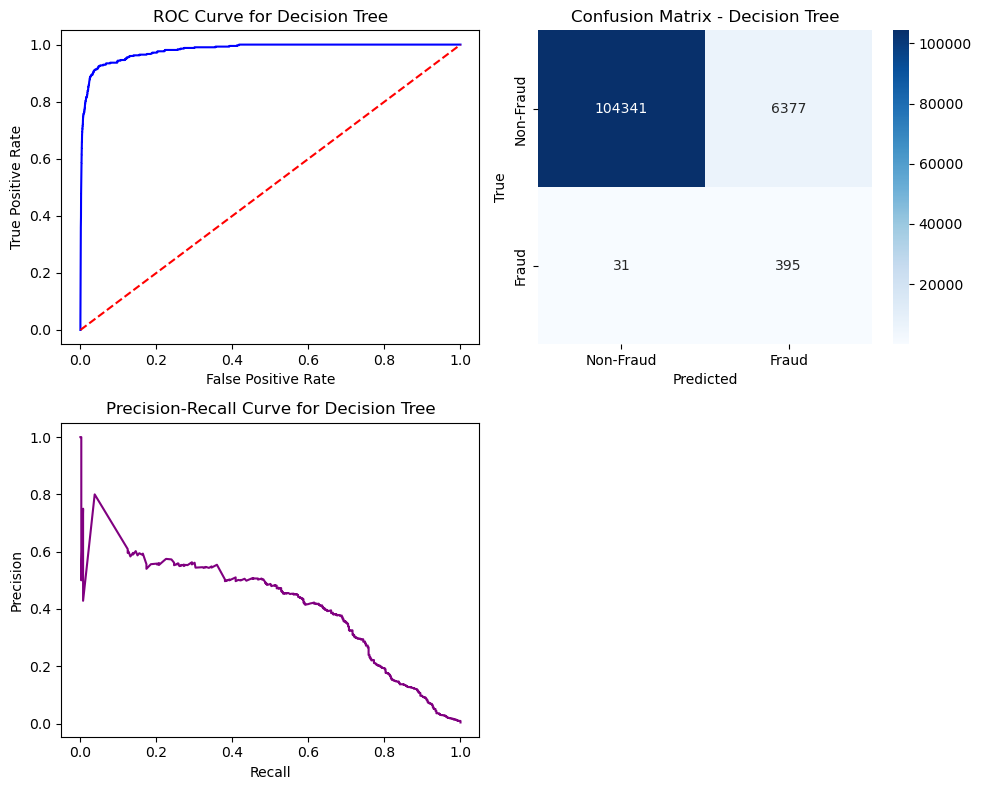

In [26]:
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
rf_model_dt = RandomForestClassifier(max_depth = 3, random_state=42)

stacking_model_dt = StackingClassifier(estimators=[('dt', dt_model), ('rf', rf_model_dt)],
final_estimator=meta_model)
#stacking random forest to use on decision tree to make it more accurate 

stacking_model_dt.fit(X_train_oversampled, y_train_oversampled)
#using the oversampled data that was trained on 20% of the rows 
#using random over sampler instead of SMOTE 

y_prob_decision = stacking_model_dt.predict_proba(X_test)[:, 1]
y_pred_decision = stacking_model_dt.predict(X_test)

fpr_decision, tpr_decision, thresholds_decision = roc_curve(y_test, y_prob_decision)

roc_auc_decision = auc(fpr_decision, tpr_decision)

cm_decision = confusion_matrix(y_test, y_pred_decision)

precision_decision, recall_decision, thresholds_decision = precision_recall_curve(y_test, y_prob_decision)


# Print the AUC
print("The area under the ROC curve is: ", roc_auc_decision)

auc_pr_decision = auc(recall_decision, precision_decision)
print('The area under the precision-recall curve is:', auc_pr_decision)


fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(fpr_decision, tpr_decision, color='blue')
axs[0, 0].plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
axs[0, 0].set_xlabel('False Positive Rate')
axs[0, 0].set_ylabel('True Positive Rate')
axs[0, 0].set_title('ROC Curve for Decision Tree')

sns.heatmap(cm_decision, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'], ax=axs[0, 1])
axs[0, 1].set_title('Confusion Matrix - Decision Tree')
axs[0, 1].set_xlabel('Predicted')
axs[0, 1].set_ylabel('True')

axs[1, 0].plot(recall_decision, precision_decision, color='purple')
axs[1, 0].set_xlabel("Recall")
axs[1, 0].set_ylabel("Precision")
axs[1, 0].set_title("Precision-Recall Curve for Decision Tree")

fig.delaxes(axs[1, 1])

plt.tight_layout()

plt.show()

The area under the precision-recall curve is: 0.29088074088730775
The area under the ROC curve is: 0.9793641028720176


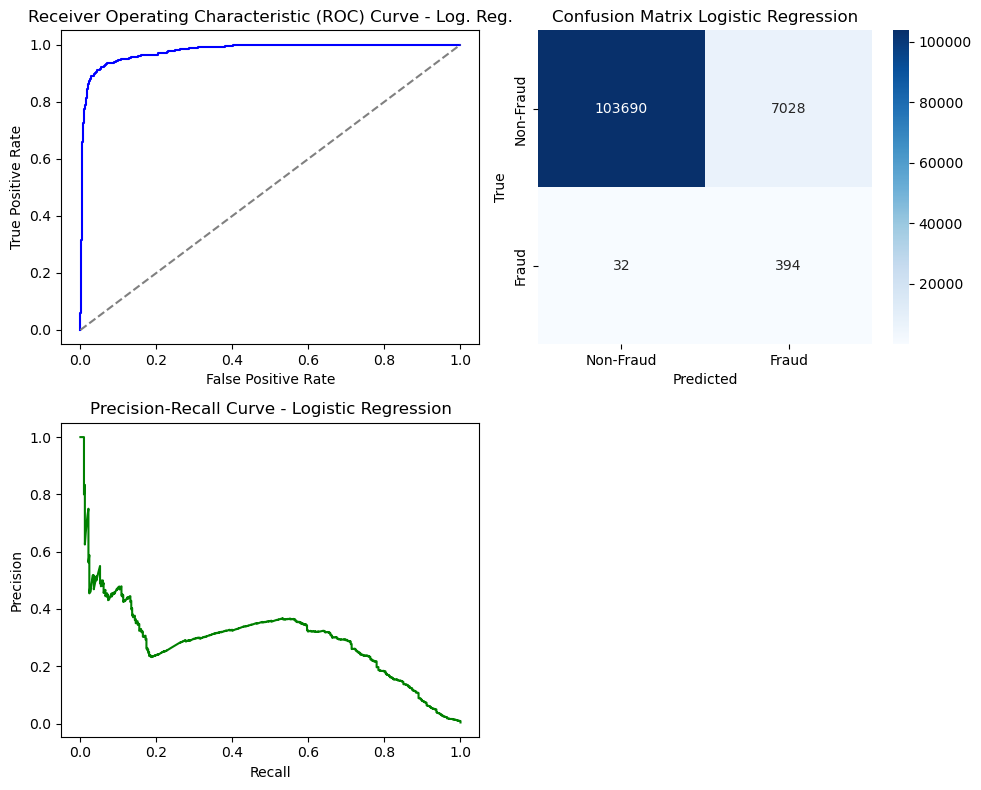

In [16]:
log_reg_model = LogisticRegression(max_iter = 10000, random_state=42)
#stacking with the rf model I called in a previous cell 

stacking_model_lr = StackingClassifier(estimators=[('rf', rf_model), ('log_reg', log_reg_model)], 
                                       final_estimator=meta_model)

stacking_model_lr.fit(X_train_oversampled, y_train_oversampled)
#using the oversampled data that was trained on 20% of the rows 
#using random over sampler instead of SMOTE 

y_pred_log_reg = stacking_model_lr.predict(X_test)
y_prob_log_reg = stacking_model_lr.predict_proba(X_test)[:, 1]

fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_prob_log_reg)

cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)

precision_log_reg, recall_log_reg, thresholds_log_reg = precision_recall_curve(y_test, y_prob_log_reg)

auc_pr_log_reg = auc(recall_log_reg, precision_log_reg)
print('The area under the precision-recall curve is:', auc_pr_log_reg)

roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
print("The area under the ROC curve is:", roc_auc_log_reg)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(fpr_log_reg, tpr_log_reg, color='blue')
axs[0, 0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axs[0, 0].set_title('Receiver Operating Characteristic (ROC) Curve - Log. Reg.')
axs[0, 0].set_xlabel('False Positive Rate')
axs[0, 0].set_ylabel('True Positive Rate')

sns.heatmap(cm_log_reg, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], 
            yticklabels=['Non-Fraud', 'Fraud'], ax=axs[0, 1])
axs[0, 1].set_title('Confusion Matrix Logistic Regression')
axs[0, 1].set_xlabel('Predicted')
axs[0, 1].set_ylabel('True')

axs[1, 0].plot(recall_log_reg, precision_log_reg, color='green')
axs[1, 0].set_title('Precision-Recall Curve - Logistic Regression')
axs[1, 0].set_xlabel('Recall')
axs[1, 0].set_ylabel('Precision')

fig.delaxes(axs[1, 1])

plt.tight_layout()

plt.show()

The area under the ROC curve is: 0.9675308848339227
The area under the precision-recall curve is: 0.4259950236937386


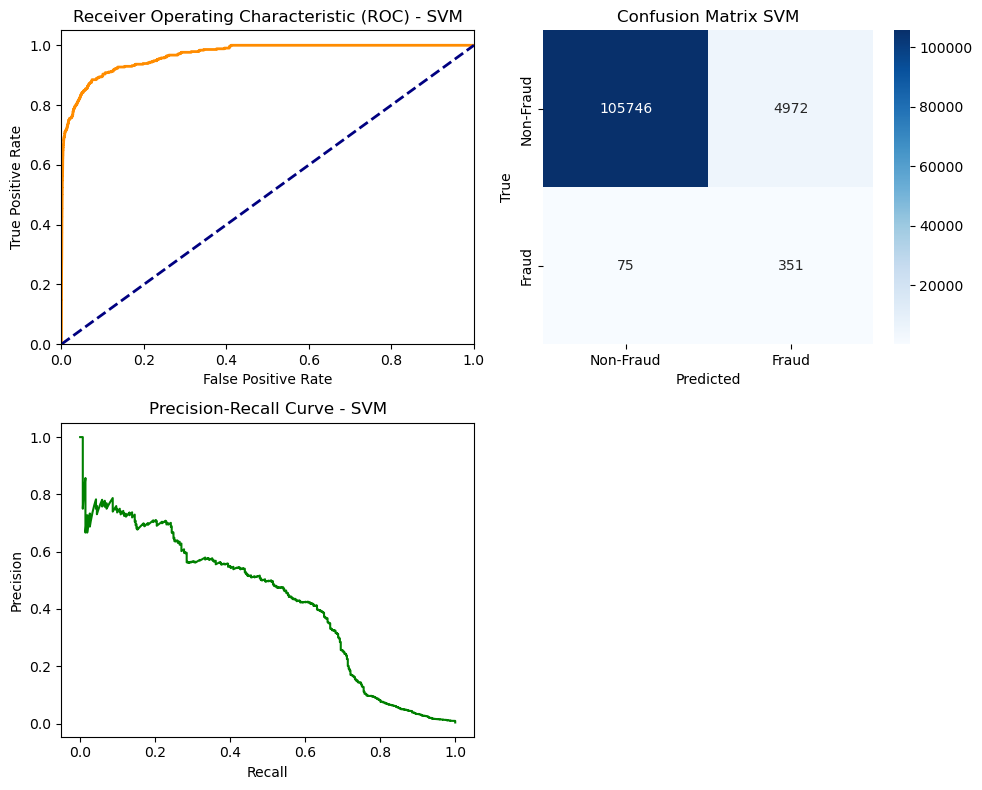

In [23]:
svm_model = svm.SVC(max_iter=30000, probability=True)
#stacking with the rf model 
#had to set max_iter=30000 to get the model to converge 
stacking_model2 = StackingClassifier(estimators=[('svm', svm_model), ('rf', rf_model)],final_estimator=meta_model)

stacking_model2.fit(X_train_oversampled_smote_scaled, y_train_oversampled_smote)
#used SMOTE oversampling here because I was getting better data with it
#had to use the 20% of rows because of the time complexity 

svm_stacked_pred = stacking_model2.predict(X_test_scaled)
svm_stacked_y_scores = stacking_model2.predict_proba(X_test_scaled)[:, 1]

#sample rows
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_stacked_y_scores)

svm_cm = confusion_matrix(y_test, svm_stacked_pred)

precision_svm, recall_svm, thresholds_svm = precision_recall_curve(y_test, svm_stacked_y_scores)

roc_auc_svm = auc(fpr_svm, tpr_svm)
print("The area under the ROC curve is:", roc_auc_svm)

auc_pr_svm = auc(recall_svm, precision_svm)
print('The area under the precision-recall curve is:', auc_pr_svm)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(fpr_svm, tpr_svm, color='darkorange', lw=2)
axs[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal line for random classifier
axs[0, 0].set_xlim([0.0, 1.0])
axs[0, 0].set_ylim([0.0, 1.05])
axs[0, 0].set_xlabel('False Positive Rate')
axs[0, 0].set_ylabel('True Positive Rate')
axs[0, 0].set_title('Receiver Operating Characteristic (ROC) - SVM')

sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'],
yticklabels=['Non-Fraud', 'Fraud'], ax=axs[0, 1])
axs[0, 1].set_title('Confusion Matrix SVM')
axs[0, 1].set_xlabel('Predicted')
axs[0, 1].set_ylabel('True')

axs[1, 0].plot(recall_svm, precision_svm, color='green')
axs[1, 0].set_title('Precision-Recall Curve - SVM')
axs[1, 0].set_xlabel('Recall')
axs[1, 0].set_ylabel('Precision')
fig.delaxes(axs[1, 1])
plt.tight_layout()

plt.show()

The area under the ROC curve is: 0.9813384437237538
The area under the precision-recall curve is: 0.4367508828365694


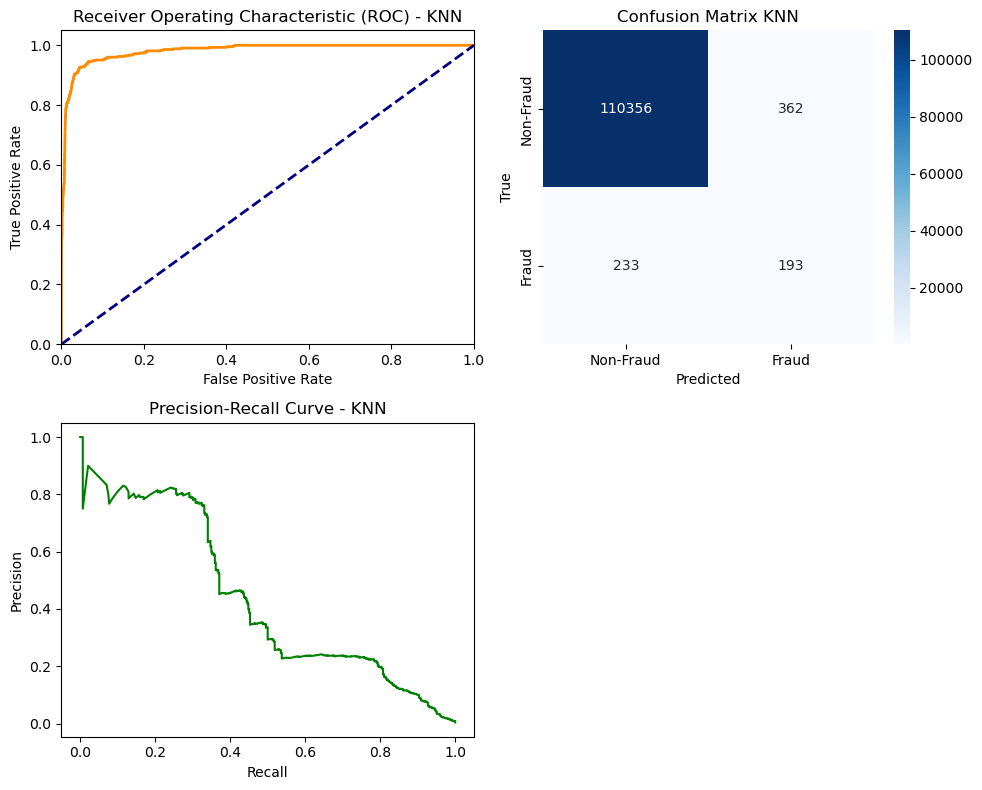

In [18]:
knn_model = KNeighborsClassifier(n_neighbors=5)
#stacking with the rf model called earlier 

stacking_model_knn = StackingClassifier(estimators=[('knn', knn_model), ('rf', rf_model)],
                                        final_estimator=meta_model)

stacking_model_knn.fit(X_train_oversampled, y_train_oversampled)
#using the oversampled data that was trained on 20% of the rows 
#using random over sampler instead of SMOTE 

y_pred_knn = stacking_model_knn.predict(X_test)

y_prob_knn = stacking_model_knn.predict_proba(X_test)[:, 1]

fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_prob_knn)

knn_cm = confusion_matrix(y_test, y_pred_knn)

precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_test, y_prob_knn)

roc_auc_knn = auc(fpr_knn, tpr_knn)
print("The area under the ROC curve is:", roc_auc_knn)

auc_pr_knn = auc(recall_knn, precision_knn)
print('The area under the precision-recall curve is:', auc_pr_knn)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].plot(fpr_knn, tpr_knn, color='darkorange', lw=2)
axs[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random classifier
axs[0, 0].set_xlim([0.0, 1.0])
axs[0, 0].set_ylim([0.0, 1.05])
axs[0, 0].set_xlabel('False Positive Rate')
axs[0, 0].set_ylabel('True Positive Rate')
axs[0, 0].set_title('Receiver Operating Characteristic (ROC) - KNN')

sns.heatmap(knn_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], 
            yticklabels=['Non-Fraud', 'Fraud'], ax=axs[0, 1])
axs[0, 1].set_title('Confusion Matrix KNN')
axs[0, 1].set_xlabel('Predicted')
axs[0, 1].set_ylabel('True')

axs[1, 0].plot(recall_knn, precision_knn, color='green')
axs[1, 0].set_title('Precision-Recall Curve - KNN')
axs[1, 0].set_xlabel('Recall')
axs[1, 0].set_ylabel('Precision')

fig.delaxes(axs[1, 1])

plt.tight_layout()

plt.show()

In [19]:
print("F-1, precision, and recall scores for the decision tree model:")
print({'F-1': f1_score(y_test, y_pred_decision, average='weighted')})
print({'Precision': precision_score(y_test, y_pred_decision, average='weighted')})
print({'Recall': recall_score(y_test, y_pred_decision, average='weighted')})

F-1, precision, and recall scores for the decision tree model:
{'F-1': 0.9669098112977266}
{'Precision': 0.9960948233728775}
{'Recall': 0.9423450658605053}


In [20]:
print("F-1, precision, and recall scores for the logistic regression model:")
print({'F-1': f1_score(y_test, y_pred_log_reg, average='weighted')})
print({'Precision': precision_score(y_test, y_pred_log_reg, average='weighted')})
print({'Recall': recall_score(y_test, y_pred_log_reg, average='weighted')})

F-1, precision, and recall scores for the logistic regression model:
{'F-1': 0.9637552110663763}
{'Precision': 0.9960632693149326}
{'Recall': 0.9364788022745267}


In [21]:
print("F-1, precision, and recall scores for the SVM model:")
print({'F-1': f1_score(y_test, svm_stacked_pred, average='weighted')})
print({'Precision': precision_score(y_test, svm_stacked_pred, average='weighted')})
print({'Recall': recall_score(y_test, svm_stacked_pred, average='weighted')})

F-1, precision, and recall scores for the SVM model:
{'F-1': 0.9734312809737478}
{'Precision': 0.9957140097181858}
{'Recall': 0.954617433239761}


In [22]:
print("F-1, precision, and recall scores for the KNN model:")
print({'F-1': f1_score(y_test, y_pred_knn, average='weighted')})
print({'Precision': precision_score(y_test, y_pred_knn, average='weighted')})
print({'Recall': recall_score(y_test, y_pred_knn, average='weighted')})

F-1, precision, and recall scores for the KNN model:
{'F-1': 0.9949970073252339}
{'Precision': 0.9954011800043067}
{'Recall': 0.9946465846109551}


First, I dropped any unnecessary columns that wouldn't have an affect on fraud detection, such as name or transaction number. This helps increase the accuracy of my models and prevents overfitting on unnecessary data. With the features I had left, I encoded any features that had object attributes, including job, gender, category, and merchant. Since the gender variable either was 'M' or 'F', I used one-hot-encoding to have the variables as binary attributes. The other features, I used target encoding which replaces each variable with the average rate that fraud occurs in this dataset. I used target encoding because it expects there to be a correlation between the attribute and whether fraud occurs, and I assumed that these attributes could be indicators. 

After running my models the first couple of times, I realized that I needed to specify the training data to reduce the computational time required. I did this by randomly sampling 20% of the rows used for training. This was especially helpful in the SVM model as the time complexity increases with the number of rows. Also with the SVM, I needed to scale my data for the model to converge properly. 

In an attempt to balance the dataset, I first tried setting the class_weight='balanced', but didn't get the best results, so I tried undersampling and oversampling. I liked the idea of undersampling the majority class to match the minority class the best, but my models weren't performing well and I assumed it was because there was too little data for the model to be trained on. Next, I tried oversampling with SMOTE and RandomOverSampler. Both of these tactics were efficient and produced good results. To obtain the true values for an imbalanced dataset for F-1, precision, and recall, I had to set the average='weighted', otherwise my scores were super low. 

Individual Models: 
- Decision Tree: 
    - I stacked the decision tree with a random forest classifier and set the max_depth=3 for each of them. This produced good results with the best confusion matrix. The confusion matrix had the least amount of false negatives. But the recall score is more poor as it's only 0.94.  
    
- Logistic Regression: 
    - The logistic regression was also stacked with a random forest classifier and improved my results as compared to the logistic regression model by itself. I got another good confusion matrix out of it, with only one more false negative than the decision tree. However, the recall score is again quite poor. 
    
- Support Vector Machine: 
    - The SVM was also stacked with a random forest classifier. The SVM gave me decent results for the F-1, precision, and recall across the board, but with more false negatives than the decision tree and logistic regression models. 
    
- k-Nearest Neighbor: 
    - The KNN was also stacked with a random forest classifier. This model gave me the best results across the board for F-1, precision, and recall, but had the worst confusion matrix with the largest amount of false negatives. 
    
If I were to choose a model, I would be between the SVM and the decision tree, both stacked with the random forest classifiers. SVM gives me consistent F-1, precision, and recall scores, but the decision tree provides the least amount of false negatives. So when it comes to detecting fraud, I would look at the confusion matricies and F-1, precision, and recall scores of both the SVM and logistic regression models. If I had to choose one, I would choose the SVM since it is more consistent between the recall and precision values. I wouldn't look at the ROC curve or precision recall curves. Since this data set is so imbalanced, the area under the ROC curve will always be high because the majority class is so large. The precision-recall curves I think are harder to read and printing out the numerical scores is more beneficial. 